# Disentanglement Metrics

In [15]:
import disent
from disent.data.groundtruth import XYObjectData
from disent.dataset.groundtruth import GroundTruthDataset
from disent.metrics import metric_dci, metric_mig
print(metric_dci, metric_mig)

<function metric_dci at 0x0000019755A14310> <function metric_mig at 0x000001977CB488B0>


In [14]:
# import torch
# import pytorch_lightning as pl
# from torch.optim import Adam
# from torch.utils.data import DataLoader
# from disent.frameworks.vae import BetaVae
# from disent.model.ae import DecoderConv64, EncoderConv64
# from disent.model import AutoEncoder
# from disent.nn.transform import ToStandardisedTensor
# from disent.util import is_test_run

# data = XYObjectData()
# dataset = GroundTruthDataset(data, transform=ToStandardisedTensor())
# dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

# def make_vae(beta):
#     return BetaVae(
#         make_optimizer_fn=lambda params: Adam(params, lr=5e-3),
#         make_model_fn=lambda: AutoEncoder(
#             encoder=EncoderConv64(x_shape=data.x_shape, z_size=6, z_multiplier=2),
#             decoder=DecoderConv64(x_shape=data.x_shape, z_size=6),
#         ),
#         cfg=BetaVae.cfg(beta=beta)
#     )

# def train(module):
#     trainer = pl.Trainer(logger=False, checkpoint_callback=False, max_steps=256, fast_dev_run=is_test_run())
#     trainer.fit(module, dataloader)

#     # we cannot guarantee which device the representation is on
#     get_repr = lambda x: module.encode(x.to(module.device))

#     # evaluate
#     return {
#         **metric_dci(dataset, get_repr, num_train=10 if is_test_run() else 1000, num_test=5 if is_test_run() else 500, boost_mode='sklearn'),
#         **metric_mig(dataset, get_repr, num_train=20 if is_test_run() else 2000),
#     }

# DEVICE = torch.device(0)
# model = make_vae(beta=4).to(DEVICE)
# a_results = train(model)
# model = make_vae(beta=0.01).to(DEVICE)
# b_results = train(model)

# print('beta=4:   ', a_results)
# print('beta=0.01:', b_results)

# Baseline: Continuous Cartpole for OpenAI Gym
- https://gist.github.com/iandanforth/e3ffb67cf3623153e968f2afdfb01dc8
- https://gist.github.com/mhr/4b77905349e888e4366e44f2c7d2ae40

In [2]:
import cv2
import matplotlib.pyplot as plt
import torch
import gym

In [81]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
Adapted from version by Ian Danforth
"""

import math
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

class ContinuousCartPoleEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self, is_pendulum_down=True, is_visual=True, height=400, width=600):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 30.0
        self.tau = 0.02  # seconds between state updates
        self.min_action = -1.0
        self.max_action = 1.0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.action_space = spaces.Box(
            low=self.min_action,
            high=self.max_action,
            shape=(1,)
        )
        self.is_visual = is_visual
        if self.is_visual:
            self.observation_space = spaces.Box(low=0, high=255, shape=(height, width, 3), dtype=np.uint8)
        else:
            self.observation_space = spaces.Box(-high, high)

        self.seed()
        self.viewer = None
        self.state = None

        self.is_pendulum_down = is_pendulum_down

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
            (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return x, x_dot, theta, theta_dot

    def step(self, action):
        """
        - step physics forward
        - done when player goes off track (x_threshold)
        - reward
            - not given for how long the pendulum is balanced, like with the Ian Danforth's original
            - loss from Paul Shen's blog post
                - (sum((theta - 0)**2) / N + theta[-1]**2 +
                   0.1 * theta_dot[-1]**2 +
                   sum((x - 0)**2) / N +
                   0.1 * x_dot[-1]**2)
            - loss from Sam Ainsworth's project
                - (θ - π)^2 + 0.1 * (θ_dot^2) + 0.001 * (u^2)
        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        # Cast action to float to strip np trappings
        force = self.force_mag * float(action)
        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state
        
        if self.is_pendulum_down:
            done = x < -self.x_threshold or x > self.x_threshold
            done = bool(done)
            
            if not done:
                cost = (theta - 0)**2 + (x - 0)**2
            else:
                cost = (theta - 0)**2 + (theta_dot - 0)**2 + (x - 0)**2 + (x_dot - 0)**2
        else:
            done = x < -self.x_threshold \
                or x > self.x_threshold \
                or theta < -self.theta_threshold_radians \
                or theta > self.theta_threshold_radians
            
            if not done:
                cost = -1.0
            else:
                cost = 0.0

        if self.is_visual:
            return self.render(mode="rgb_array"), -cost, done, {}
        else:
            return np.array(self.state), -cost, done, {}

    def reset(self):
        # x, x_dot, theta, theta_dot
        self.state = np.zeros((4,))
        if self.is_pendulum_down:
            self.state[2] = math.pi # angle = facing down
        self.steps_beyond_done = None
        if self.is_visual:
            return self.render(mode="rgb_array")
        else:
            return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width /world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * 1.0
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen-polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

        if self.state is None:
            return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=(mode == 'rgb_array'))

    def close(self):
        if self.viewer:
            self.viewer.close()

# Stable Baselines3
- https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

In [70]:
from stable_baselines3 import SAC, PPO

In [82]:
is_visual = False
is_pendulum_down = False
# env = gym.make("CartPole-v1")
env = ContinuousCartPoleEnv(is_pendulum_down=is_pendulum_down, is_visual=is_visual)

if is_visual:
    model = PPO("CnnPolicy", env, verbose=1)
else:
    model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

obs = env.reset()
for i in range(1000):
#     # take a random action
#     obs, reward, done, info = env.step(env.action_space.sample())
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
#     img = env.render()
    if done:
        obs = env.reset()

env.close()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16       |
|    ep_rew_mean     | 15       |
| time/              |          |
|    fps             | 494      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 19.8        |
|    ep_rew_mean          | 18.8        |
| time/                   |             |
|    fps                  | 370         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012862312 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 151          |
|    ep_rew_mean          | 150          |
| time/                   |              |
|    fps                  | 283          |
|    iterations           | 11           |
|    time_elapsed         | 79           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0049472703 |
|    clip_fraction        | 0.0688       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.26        |
|    explained_variance   | 0.851        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.49         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00428     |
|    std                  | 0.857        |
|    value_loss           | 30.5         |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 167         |
|    ep_rew_mean          | 166         |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 20          |
|    time_elapsed         | 144         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.007450079 |
|    clip_fraction        | 0.0337      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | -0.00409    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000482   |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00127    |
|    std                  | 0.841       |
|    value_loss           | 0.218       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 383         |
|    ep_rew_mean          | 382         |
| time/                   |             |
|    fps                  | 261         |
|    iterations           | 29          |
|    time_elapsed         | 227         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.003620529 |
|    clip_fraction        | 0.035       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.14       |
|    explained_variance   | -0.0305     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000903    |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00277    |
|    std                  | 0.746       |
|    value_loss           | 0.00365     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 383         |
|    ep_rew_mean          | 382         |
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 38          |
|    time_elapsed         | 299         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.004672464 |
|    clip_fraction        | 0.0435      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | -0.623      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00526     |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00264    |
|    std                  | 0.701       |
|    value_loss           | 0.000113    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

KeyboardInterrupt: 

In [83]:
env.close()

### Test out trained model!

In [84]:
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    img = env.render()
    if done:
        obs = env.reset()

env.close()

In [76]:
env.close()

### Test environment properties

TypeError: Invalid shape (4,) for image data

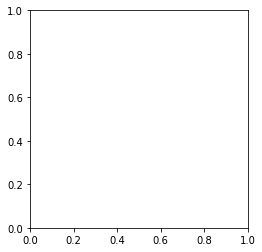

In [58]:
plt.imshow(obs, cmap="gray")

In [53]:
import stable_baselines3.common.env_checker as env_checker

In [83]:
env = ContinuousCartPoleEnv(is_visual=True)

In [84]:
# needed to verify that is_visual works
# isn't relevant for a vanilla state and will actually break, but ignore that
env_checker.check_env(env)

In [85]:
env.close()